## Question 1

In [55]:
from abc import ABC, abstractmethod
import scipy.stats as stats
import numpy as np

class Model(ABC):
    @abstractmethod
    def sample(self, size=None, *args, **kwargs):
        pass

    @abstractmethod
    def pdf(self, x):
        pass

class Normal(Model):
    def __init__(self, mu=0, sigma=1):
        self.mu = mu
        self.sigma = sigma
    
    def sample(self, size=None):
        return stats.norm.rvs(self.mu, self.sigma, size=size)

    def pdf(self, x):
        return stats.norm.pdf(x, self.mu, self.sigma)

def run_abc_rejection(N, observed_data, prior_model, generate_data, compute_discrepancy, tolerance=0.1):
    sample = []
    num_tries = 0

    while len(sample) < N:
        num_tries += 1
        theta = prior_model.sample()
        generated_data = generate_data(theta, len(observed_data))
        if compute_discrepancy(observed_data, generated_data) < tolerance:
            sample.append(theta)
    
    return sample, N / num_tries

In [56]:
# Constants
example_a = 1
example_p = 1/2
example_M = 100
example_sigma_1 = np.sqrt(0.1)
example_sigma = np.sqrt(3)
example_mean = 0
example_N = 500

class ExampleLikelihoodModel(Model):
    def __init__(self, theta, a, sigma, p):
        self.theta = theta
        self.a = a
        self.sigma = sigma
        self.p = p
    
    def sample(self, size=None):
        prob = stats.uniform.rvs(0, 1)

        if prob < self.p:
            return stats.norm.rvs(self.theta, self.sigma, size=size)

        return stats.norm.rvs(self.theta+self.a, self.sigma, size=size)

    def pdf(self, x):
        return NotImplementedError

class ExamplePosteriorModel(Model):
    def __init__(self, M, mean, a, sigma, sigma_1):
        self.a = a
        self.sigma = sigma
        self.sigma_1 = sigma_1
        self.mean = mean
        self.M = M
        self.alpha = 1 / (1 + np.exp(a * (mean - a/2) * (self.M / (self.M*sigma**2 + sigma_1**2))))
        self.normal_1 = Normal((sigma**2 / (sigma**2 + sigma_1**2/self.M)) * mean, sigma_1**2/(self.M + sigma_1**2/sigma**2))
        self.normal_2 = Normal((sigma**2 / (sigma**2 + sigma_1**2/self.M)) * (mean-a), sigma_1**2/(self.M + sigma_1**2/sigma**2))
    
    def sample(self, size=None):
        return NotImplementedError
    
    def pdf(self, x):
        return self.alpha * self.normal_1.pdf(x) + (1-self.alpha) * self.normal_2.pdf(x)

def generate_data(theta, size):
    return ExampleLikelihoodModel(theta, example_a, example_sigma_1, example_p).sample(size=size)

def compute_example_discrepancy(observed_data, generated_data):
    return np.abs(np.mean(generated_data) - example_mean)

prior_model = Normal(0, example_sigma)
example_theta = prior_model.sample()
observed_data = generate_data(example_theta, example_M)
posterior_model = ExamplePosteriorModel(example_M, example_mean, example_a, example_sigma, example_sigma_1)

tolerances = [0.75, 0.25, 0.1, 0.025]
q1_tolerance_samples = []

for tolerance in tolerances:
    sample, acceptance_rate = run_abc_rejection(example_N, observed_data, prior_model, generate_data, compute_example_discrepancy, tolerance)
    print(f"tolerance: {tolerance}, acceptance rate: {acceptance_rate*100:.2f}%")
    q1_tolerance_samples.append(sample)

tolerance: 0.75, acceptance rate: 31.93%
tolerance: 0.25, acceptance rate: 11.07%
tolerance: 0.1, acceptance rate: 3.98%
tolerance: 0.025, acceptance rate: 1.03%


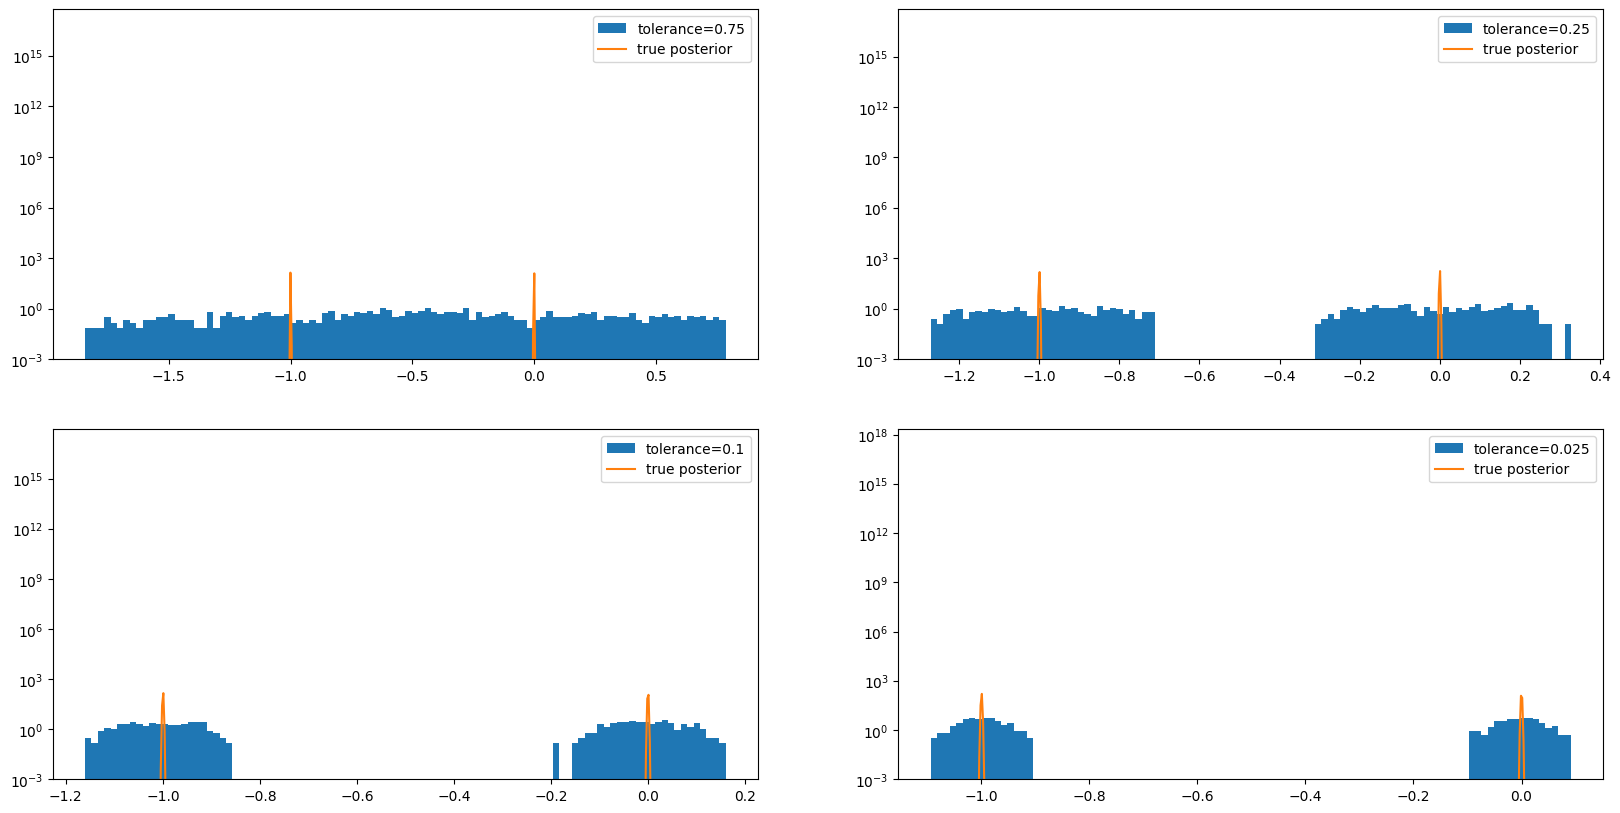

In [70]:
import matplotlib.pyplot as plt

def plot_sample(samples, posterior_model, tolerances, set_log=True, set_ylim=True):
    fig, axes = plt.subplots(2, 2, figsize=(20, 10))

    for i, sample in enumerate(samples):
        axis = axes[i//2, i%2]
        axis.hist(sample, bins=100, label=f"tolerance={tolerances[i]}", density=True)
        x = np.linspace(min(sample), max(sample), example_N)
        posterior_density = [posterior_model.pdf(theta) for theta in x]
        axis.plot(x, posterior_density, label="true posterior")
        if set_log:
            axis.set_yscale("log")
        if set_ylim:
            axis.set_ylim(bottom=0.001)
        axis.legend()
    plt.show()

plot_sample(q1_tolerance_samples, posterior_model, tolerances)

## Question 2

## Question 3

In [68]:
from tqdm import tqdm

def run_abc_mcmc(N, observed_data, make_proposal_model, target_model, generate_data, compute_discrepancy, tolerance=0.1, theta_0=0):
    sample = [theta_0]
    num_tries = 0

    with tqdm(total=N, desc="Generating samples") as pbar:
        while len(sample) < N:
            num_tries += 1
            current_theta = sample[-1]
            current_proposal_model = make_proposal_model(current_theta)
            new_theta = current_proposal_model.sample()
            new_proposal_model = make_proposal_model(new_theta)
            generated_data = generate_data(new_theta, len(observed_data))
            
            if compute_discrepancy(observed_data, generated_data) < tolerance:
                alpha = min(1, (target_model.pdf(new_theta) * new_proposal_model.pdf(current_theta)) / (target_model.pdf(current_theta) * current_proposal_model.pdf(new_theta)))
                prob = stats.uniform.rvs(0, 1)
                if prob < alpha:
                    sample.append(new_theta)
                    pbar.update(1)
    
    return sample, N / num_tries

class ExampleProposalModel(Model):
    def __init__(self, theta, sigma):
        self.theta = theta
        self.sigma = sigma
    
    def sample(self, size=None):
        return stats.norm.rvs(self.theta, self.sigma, size=size)

    def pdf(self, x):
        return stats.norm.pdf(x, self.theta, self.sigma)

def make_example_proposal_model(theta):
    return ExampleProposalModel(theta, np.sqrt(0.1))

q3_tolerance_samples = []
burn_in = 100

for tolerance in tolerances:
    sample, acceptance_rate = run_abc_mcmc(example_N+burn_in, observed_data, make_example_proposal_model, posterior_model, generate_data, compute_example_discrepancy, tolerance)
    print(f"tolerance: {tolerance}, acceptance rate: {acceptance_rate*100:.2f}%")
    q3_tolerance_samples.append(sample[burn_in:])

Generating samples: 100%|█████████▉| 599/600 [03:07<00:00,  3.20it/s]


tolerance: 0.75, acceptance rate: 0.21%


Generating samples: 100%|█████████▉| 599/600 [02:01<00:00,  4.94it/s]


tolerance: 0.25, acceptance rate: 0.20%


Generating samples: 100%|█████████▉| 599/600 [01:12<00:00,  8.29it/s]


tolerance: 0.1, acceptance rate: 0.23%


Generating samples: 100%|█████████▉| 599/600 [01:38<00:00,  6.07it/s]

tolerance: 0.025, acceptance rate: 0.12%


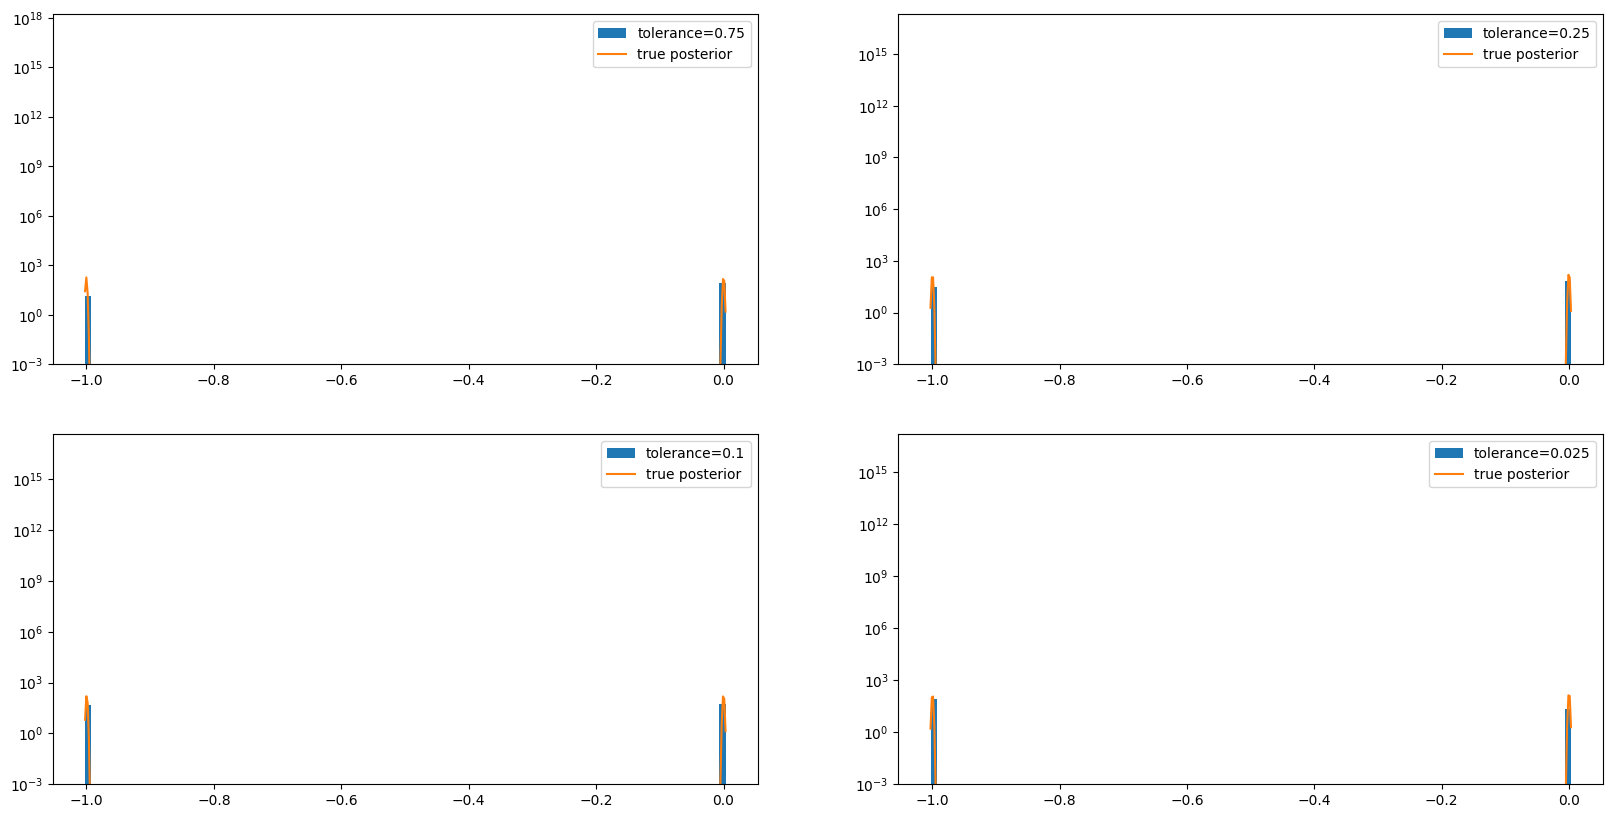

In [72]:
plot_sample(q3_tolerance_samples, posterior_model, tolerances)

## Question 4

In [32]:
class BrownianMotion(Model):
    def __init__(self, dt=0.01) -> None:
        self.dt = dt

    def sample(self, size=None):
        return stats.norm.rvs(0, np.sqrt(self.dt), size=size)
    
    def pdf(self, x):
        return NotImplementedError

class PharmacokineticModel(Model):
    def __init__(self, D, K_a, K_e, Cl, sigma, dt=0.01):
        self.D = D
        self.K_a = K_a
        self.K_e = K_e
        self.Cl = Cl
        self.sigma = sigma
        self.dt = dt
        self.brownian = BrownianMotion(dt=dt)
    
    def sample(self, size=None, x_t=0, t=0.01):
        return ((self.D * self.K_a * self.K_e * np.exp(-self.K_a * t))/self.Cl - self.K_e * x_t) * self.dt + self.sigma * self.brownian.sample(size=size)

    def pdf(self, x):
        return NotImplementedError

def run_euler_maruyama(sampling_times, model, x_0=0, dt=0.01, debug=False):
    x = [x_0]
    sample = []
    t = 0

    while len(sample) < len(sampling_times):
        x_t = x[-1]
        x_t_plus_1 = x_t + model.sample(x_t=x_t, t=t)
        x.append(x_t_plus_1)

        if any([np.isclose(t, sampling_time) for sampling_time in sampling_times]):
            if debug:
                print(f"t={t}, x_t={x_t_plus_1}")
            sample.append(x_t_plus_1)
        
        t = t + dt

    return sample

sampling_dt = 0.005
sampling_times = [0.25, 0.5, 1, 2, 3.5, 5, 7, 9, 12]
pharmacokinetic_model = PharmacokineticModel(D=4, K_a=1.5, K_e=0.08, Cl=0.04, sigma=0.2, dt=sampling_dt)
sample = run_euler_maruyama(sampling_times, pharmacokinetic_model, dt=sampling_dt, debug=True)

t=0.2500000000000001, x_t=2.6259834036300522
t=0.5000000000000003, x_t=4.152368479587508
t=1.0000000000000007, x_t=5.831452593863199
t=1.9999999999999793, x_t=6.818662884497487
t=3.4999999999999476, x_t=6.405903695301859
t=4.999999999999916, x_t=5.821150597809156
t=6.999999999999873, x_t=4.819312019868345
t=9.000000000000007, x_t=4.200914513054825
t=12.000000000000476, x_t=3.5328935983616536


In [43]:
import pandas as pd
import statsmodels.api as sm
from tqdm import tqdm

class LogNormal(Model):
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
    
    def sample(self, size=None):
        return np.exp(stats.norm.rvs(loc=self.mu, scale=self.sigma, size=size))

    def pdf(self, x):
        return np.exp(stats.norm.pdf(x, self.mu, self.sigma))

def generate_train_data(train_size=100, target="K_a"):
    prior_K_a = LogNormal(0.14, 0.4)
    prior_K_e = LogNormal(-2.7, 0.6)
    prior_Cl = LogNormal(-3, 0.8)
    prior_sigma = LogNormal(-1.1, 0.3)

    prior_map = {
        "K_a": prior_K_a,
        "K_e": prior_K_e,
        "Cl": prior_Cl,
        "sigma": prior_sigma
    }

    fixed_priors = {
        "K_a": 1.5,
        "K_e": 0.08,
        "Cl": 0.04,
        "sigma": 0.2
    }

    train_data = []

    for i in tqdm(range(train_size), total=train_size, desc="Generating train data"):
        priors = {k: prior_map[k].sample() if k == target else fixed_priors[k] for k in prior_map.keys()}
        pharmacokinetic_model = PharmacokineticModel(D=4, dt=sampling_dt, **priors)
        sample = run_euler_maruyama(sampling_times, pharmacokinetic_model, dt=sampling_dt)
        train_data.append(sample + [priors["K_a"], priors["K_e"], priors["Cl"], priors["sigma"]])

    train_df = pd.DataFrame(train_data, columns=[f"x_[t={t}]" for t in sampling_times] + ["K_a", "K_e", "Cl", "sigma"])

    return train_df

def train_model(train_df, target):
    train_x = train_df[[col for col in train_df.columns if col.startswith("x_")]]
    train_y = train_df[target]
    train_x = sm.add_constant(train_x)
    model = sm.OLS(train_y, train_x).fit()
    return model

k_a_train_df = generate_train_data(train_size=100, target="K_a")
k_a_model = train_model(k_a_train_df, target="K_a")
print(k_a_model.summary())

Generating train data: 100%|██████████| 100/100 [01:47<00:00,  1.07s/it]

                            OLS Regression Results                            
Dep. Variable:                    K_a   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     506.4
Date:                Mon, 25 Dec 2023   Prob (F-statistic):           4.82e-73
Time:                        13:14:19   Log-Likelihood:                 140.27
No. Observations:                 100   AIC:                            -260.5
Df Residuals:                      90   BIC:                            -234.5
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2143      0.114      1.880      0.0

In [44]:
k_e_train_df = generate_train_data(train_size=100, target="K_e")
k_e_model = train_model(k_e_train_df, target="K_e")
print(k_e_model.summary())

Generating train data: 100%|██████████| 100/100 [01:51<00:00,  1.12s/it]

                            OLS Regression Results                            
Dep. Variable:                    K_e   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     3043.
Date:                Mon, 25 Dec 2023   Prob (F-statistic):          9.52e-108
Time:                        13:17:35   Log-Likelihood:                 463.13
No. Observations:                 100   AIC:                            -906.3
Df Residuals:                      90   BIC:                            -880.2
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.001      0.872      0.3

In [45]:
cl_train_df = generate_train_data(train_size=100, target="Cl")
cl_model = train_model(cl_train_df, target="Cl")
print(cl_model.summary())

Generating train data: 100%|██████████| 100/100 [01:41<00:00,  1.02s/it]

                            OLS Regression Results                            
Dep. Variable:                     Cl   R-squared:                       0.290
Model:                            OLS   Adj. R-squared:                  0.219
Method:                 Least Squares   F-statistic:                     4.082
Date:                Mon, 25 Dec 2023   Prob (F-statistic):           0.000202
Time:                        13:19:25   Log-Likelihood:                 138.93
No. Observations:                 100   AIC:                            -257.9
Df Residuals:                      90   BIC:                            -231.8
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1079      0.009     12.522      0.0

In [46]:
sigma_train_df = generate_train_data(train_size=100, target="sigma")
sigma_model = train_model(sigma_train_df, target="sigma")
print(sigma_model.summary())

Generating train data: 100%|██████████| 100/100 [01:42<00:00,  1.03s/it]

                            OLS Regression Results                            
Dep. Variable:                  sigma   R-squared:                       0.163
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     1.941
Date:                Mon, 25 Dec 2023   Prob (F-statistic):             0.0559
Time:                        13:23:37   Log-Likelihood:                 100.84
No. Observations:                 100   AIC:                            -181.7
Df Residuals:                      90   BIC:                            -155.6
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6159      0.174      3.537      0.0

In [51]:
sigma_model.params

const         0.615895
x_[t=0.25]    0.152885
x_[t=0.5]    -0.161969
x_[t=1]      -0.044628
x_[t=2]       0.056377
x_[t=3.5]    -0.029918
x_[t=5]      -0.010909
x_[t=7]       0.017208
x_[t=9]       0.019393
x_[t=12]     -0.005869
dtype: float64

In [53]:
coefficients = np.vstack([k_a_model.params, k_e_model.params, cl_model.params, sigma_model.params])

def weighted_euclidean_norm(x, weights):
    return np.sqrt(np.sum(np.square(x)/np.square(weights)))

def compute_pharmacokinetics_discrepancy(coefficients, theta_0, observed_data, generated_data):
    s_observed_data = np.dot(coefficients, np.array(observed_data).reshape(-1, 1))
    s_generated_data = np.dot(coefficients, np.array(generated_data).reshape(-1, 1))
    return weighted_euclidean_norm(s_generated_data - s_observed_data, weights=theta_0)

def generate_pharmacokinetics_data(theta, size):
    pharmacokinetic_model = PharmacokineticModel(D=4, K_a=theta[0], K_e=theta[1], Cl=theta[2], sigma=theta[3], dt=sampling_dt)
    return run_euler_maruyama(sampling_times, pharmacokinetic_model, dt=sampling_dt)

class PharmacokineticPriorModel(Model):
    def __init__(self):
        self.prior_K_a = LogNormal(0.14, 0.4)
        self.prior_K_e = LogNormal(-2.7, 0.6)
        self.prior_Cl = LogNormal(-3, 0.8)
        self.prior_sigma = LogNormal(-1.1, 0.3)
    
    def sample(self, size=None):
        return [self.prior_K_a.sample(), self.prior_K_e.sample(), self.prior_Cl.sample(), self.prior_sigma.sample()]

    def pdf(self, x):
        return NotImplementedError

class PharmacokineticProposalModel(Model):
    def __init__(self):
        pass
    
    def sample(self, size=None):
        pass

    def pdf(self, x):
        pass

pharmacokinetics_tolerances = [0.25, 0.7, 1]
pharmacokinetics_N = 10000
theta_0 = [1.15, 0.07, 0.05, 0.33]

(4, 10)

## Question 5

## Question 6